In [300]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import coint
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')

In [301]:
crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 
                       'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD', 'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 
                       'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 
                       'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 
               'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB',  'CFG', 'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 
               'WAL', 'PACW', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC',
                'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                  '^RUT', '^VIX', '^TNX']

# Download data for the below dates
start = '2021-01-01'
end = '2023-12-31'
tickers = crypto_forex_stocks + bank_stocks + global_indexes
tickers_map = {ticker: yf.Ticker(ticker).history(start=start, end=end) for ticker in tickers}

 BNPQY: No timezone found, symbol may be delisted


In [302]:
# Cleaning data to ensure all columns have the same length
def clean_data(data_map):
    for data in data_map.values():
        data.index = pd.to_datetime(data.index).tz_localize(None)
        
    df = pd.concat([data['Close'] for data in data_map.values()], axis=1, keys=data_map.keys())

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.interpolate(method='cubic', inplace=True)
    df.fillna(method='pad', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    return df    

In [303]:
cleaned_data = clean_data(tickers_map)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2021-01-01 to 2023-12-30
Freq: D
Data columns (total 89 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BTC-USD   1094 non-null   float64
 1   ETH-USD   1094 non-null   float64
 2   BNB-USD   1094 non-null   float64
 3   XRP-USD   1094 non-null   float64
 4   ADA-USD   1094 non-null   float64
 5   DOGE-USD  1094 non-null   float64
 6   ETC-USD   1094 non-null   float64
 7   XLM-USD   1094 non-null   float64
 8   AAVE-USD  1094 non-null   float64
 9   EOS-USD   1094 non-null   float64
 10  XTZ-USD   1094 non-null   float64
 11  ALGO-USD  1094 non-null   float64
 12  XMR-USD   1094 non-null   float64
 13  KCS-USD   1094 non-null   float64
 14  MKR-USD   1094 non-null   float64
 15  BSV-USD   1094 non-null   float64
 16  RUNE-USD  1094 non-null   float64
 17  DASH-USD  1094 non-null   float64
 18  KAVA-USD  1094 non-null   float64
 19  ICX-USD   1094 non-null   float64
 20  LINA

In [304]:
# Engle & Granger 2-step cointegration test to determine suitable pairs to trade
def coint_matrix(df):
    tickers = df.columns
    p_values = np.ones((len(tickers), len(tickers)))
    close_matrix = np.column_stack([df[ticker] for ticker in tickers])
    for i, j in combinations(range(len(tickers)), 2):
        result = coint(close_matrix[:, i], close_matrix[:, j])
        if result[1] < 0.05:
            p_values[i, j] = result[1]

    pairs = [(tickers[i], tickers[j], p_values[i, j]) for i, j in zip(*np.where(p_values < 0.05))]

    return p_values, pairs

In [305]:
p_values, pairs = coint_matrix(cleaned_data)

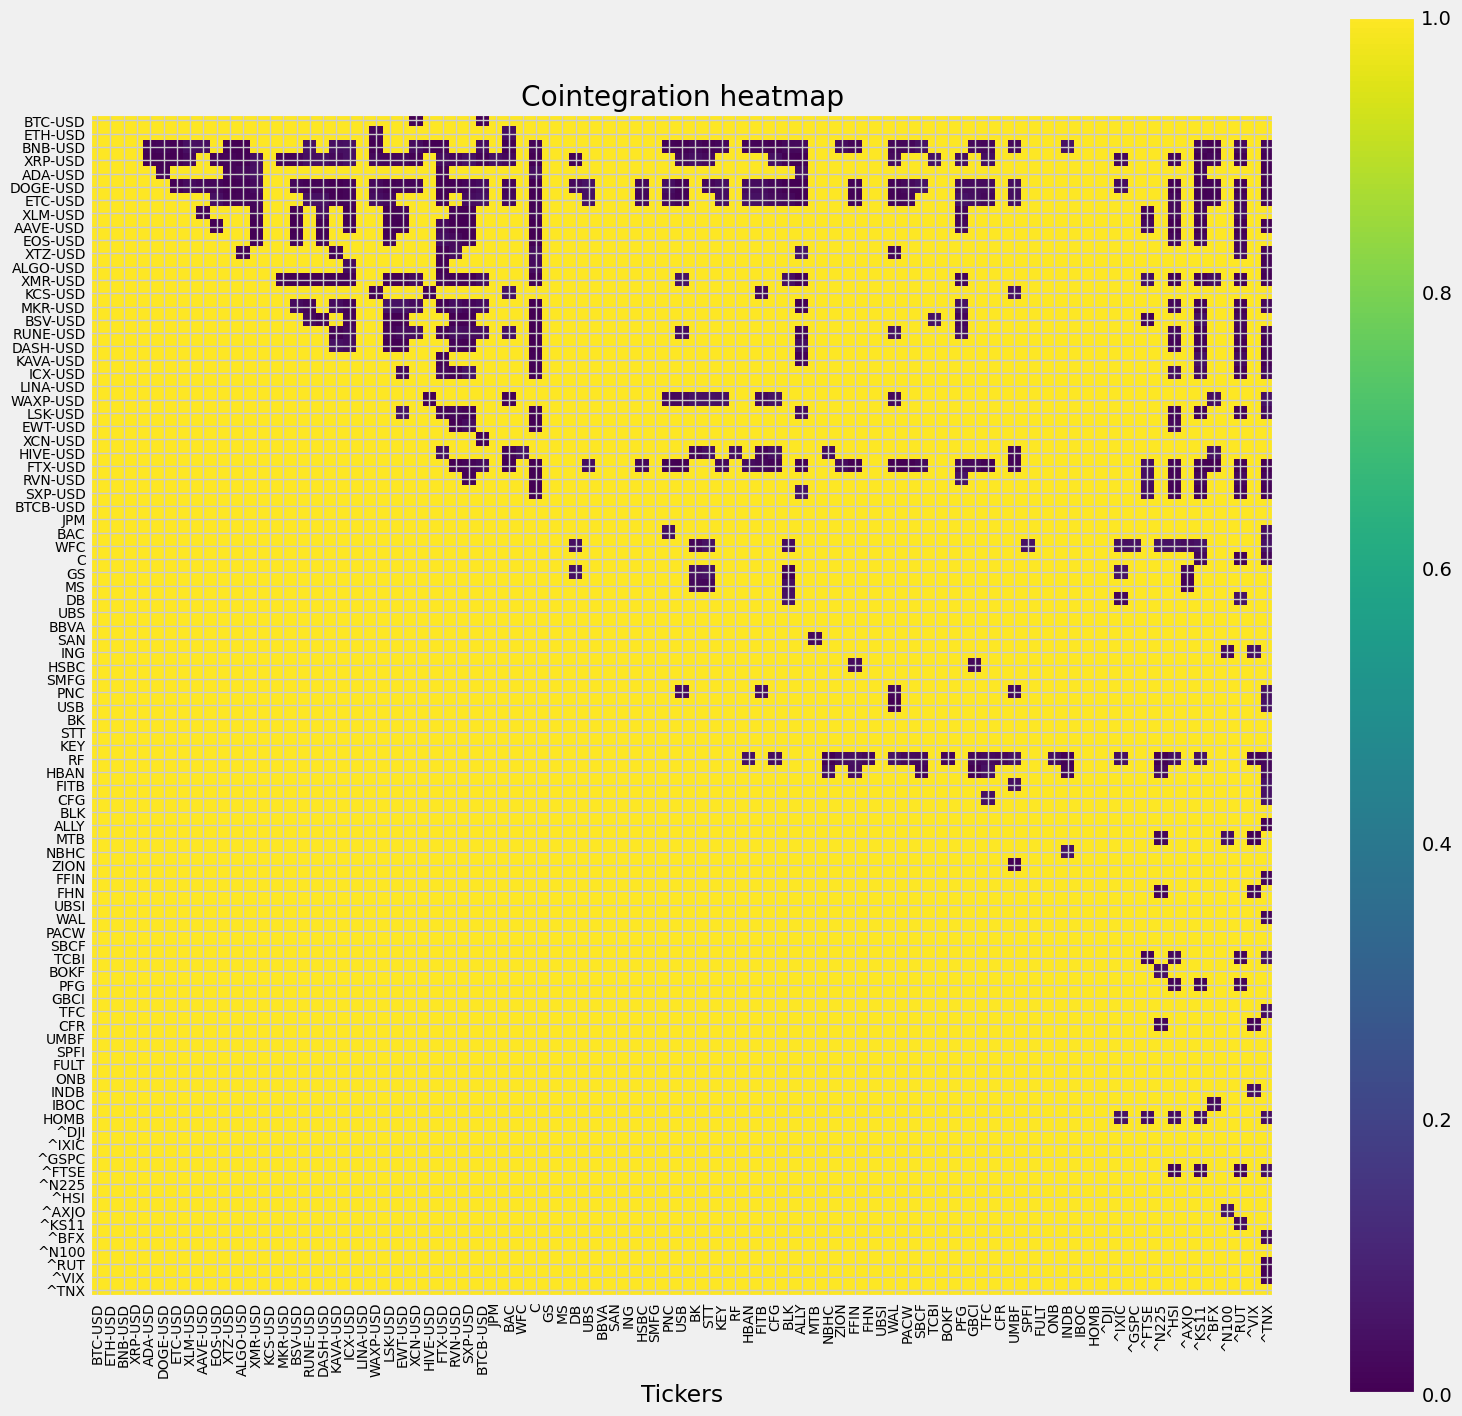

In [306]:
# Heatmap of the p-values from the conintegration test to give an idea of which pairs are cointegrated
fig, ax = plt.subplots(figsize=(17,17))
heatmap = ax.imshow(p_values, cmap='viridis')
colorbar = plt.colorbar(heatmap)
ax.set_xticks(np.arange(len(cleaned_data.columns)), labels=cleaned_data.columns, fontsize=10)
ax.set_yticks(np.arange(len(cleaned_data.columns)), labels=cleaned_data.columns, fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('Cointegration heatmap')
plt.xlabel('Tickers')
plt.show()

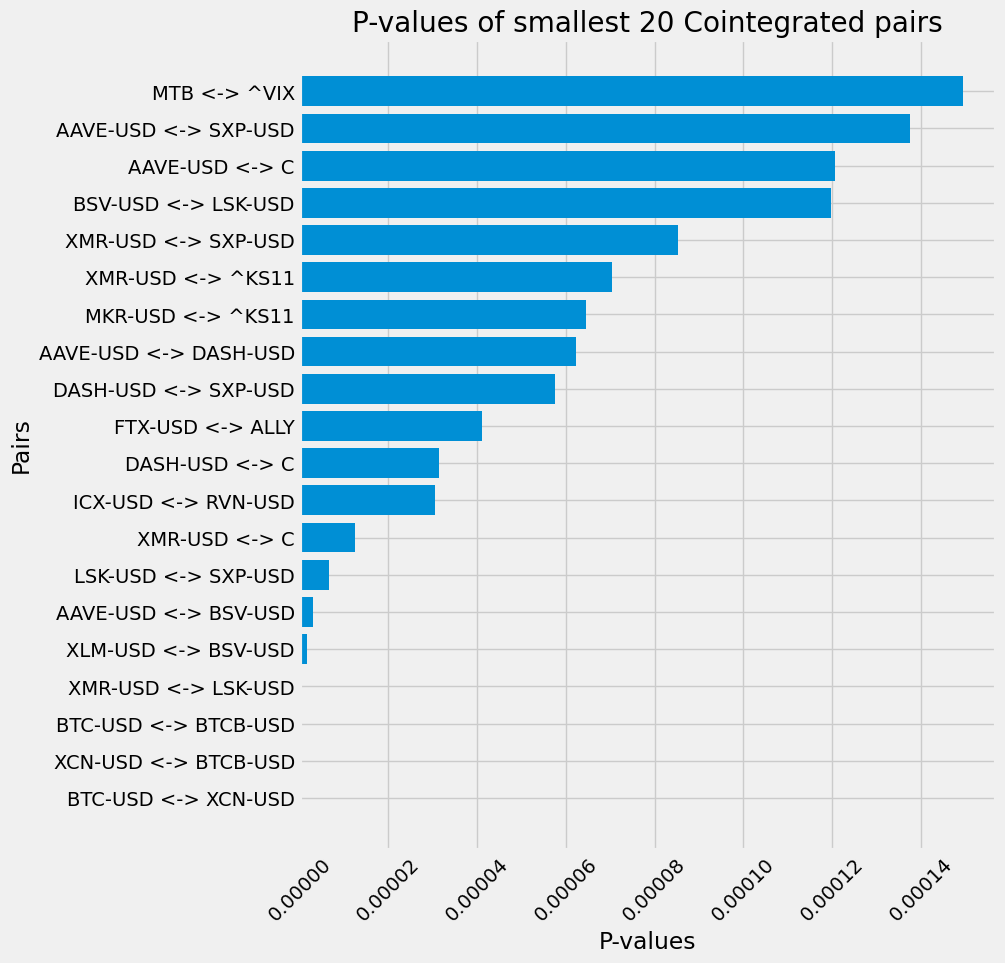

In [307]:
# Identifying the most cointegrated pairs by plotting the 20 most suitable pairs
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sub_sorted_pairs = sorted_pairs[0:20]
sub_sorted_pairs
pair_labels, p_vals = zip(*[(f'{y1} <-> {y2}', p) for y1, y2, p in sub_sorted_pairs])
plt.figure(figsize=(8,10))
plt.barh(pair_labels, p_vals)
plt.xticks(rotation=45)
plt.title('P-values of smallest 20 Cointegrated pairs')
plt.xlabel('P-values')
plt.ylabel('Pairs')
plt.show()

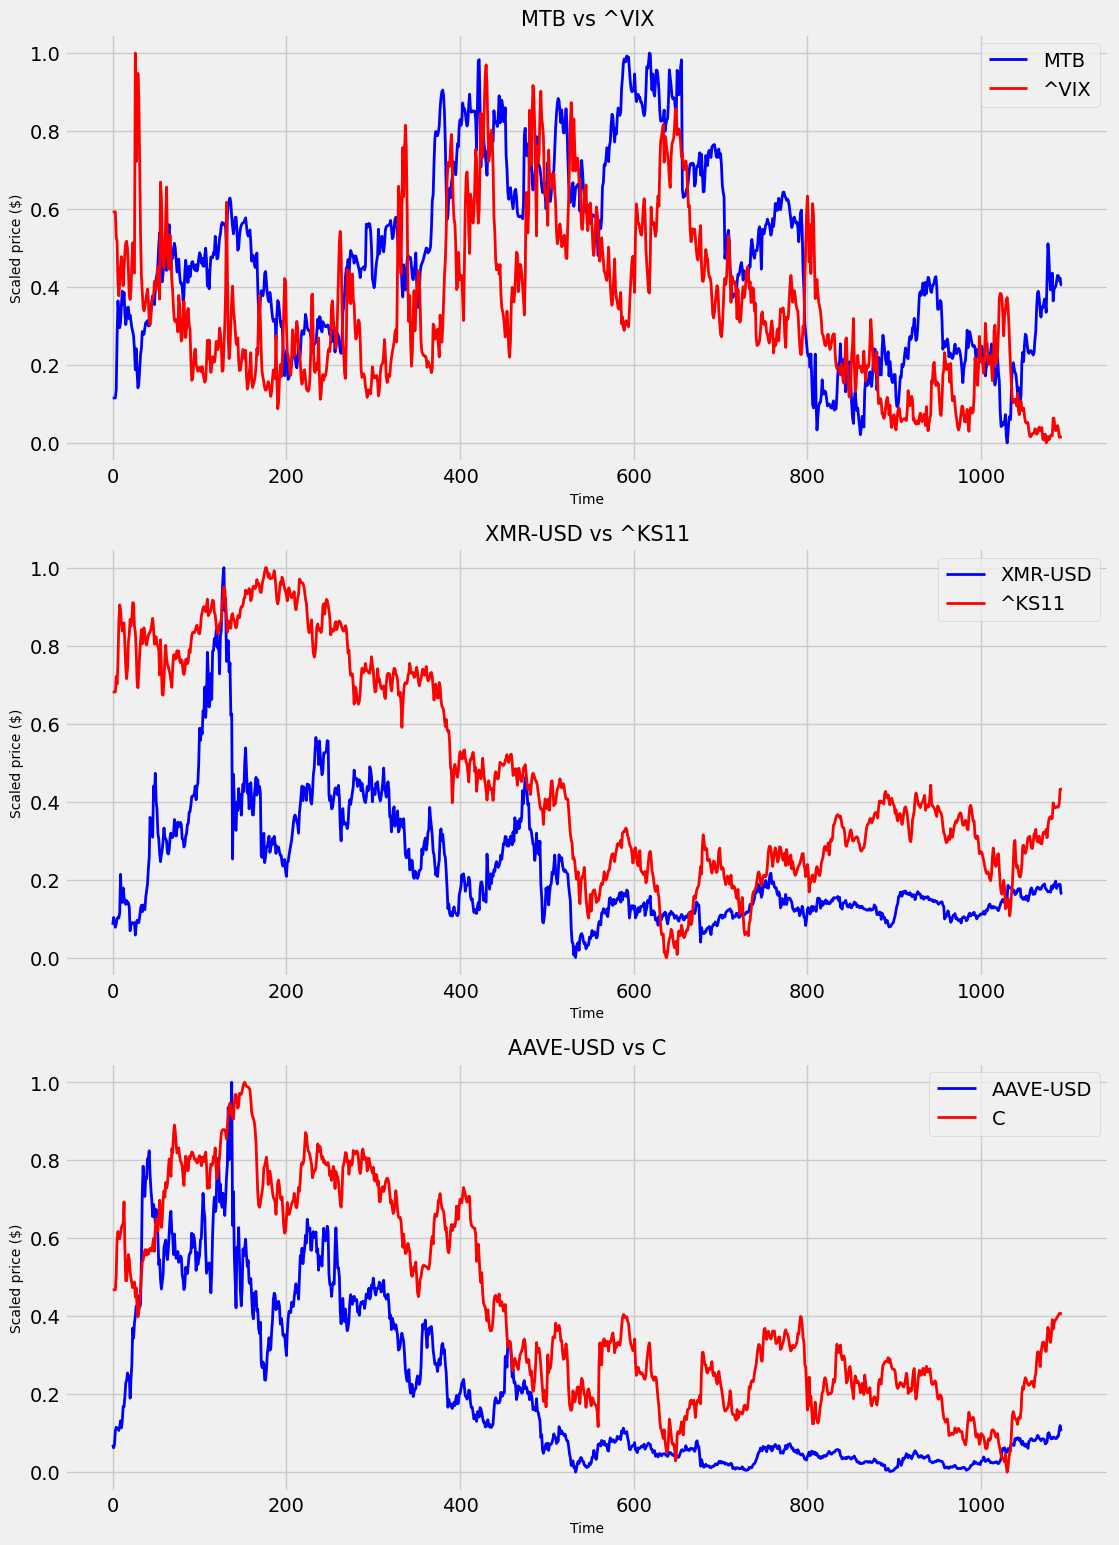

In [308]:
# The following 3 pairs were selected to have a good mix of all assets
ticker_pairs = [('MTB', '^VIX'), ('XMR-USD', '^KS11'), ('AAVE-USD', 'C')]
fig, ax = plt.subplots(3, 1, figsize=(12,18))
scaler = MinMaxScaler()
for i, (t1, t2) in enumerate(ticker_pairs):
    scaled_data_1 = scaler.fit_transform(cleaned_data[t1].values.reshape(-1, 1))
    scaled_data_2 = scaler.fit_transform(cleaned_data[t2].values.reshape(-1, 1))
    ax[i].plot(scaled_data_1, label=t1, color='blue', linewidth=2.0)
    ax[i].plot(scaled_data_2, label=t2, color='red', linewidth=2.0)
    ax[i].set_title(f'{t1} vs {t2}', fontsize=15)
    ax[i].set_ylabel('Scaled price ($)', fontsize=10)
    ax[i].set_xlabel('Time', fontsize=10)
    ax[i].legend()

plt.show()

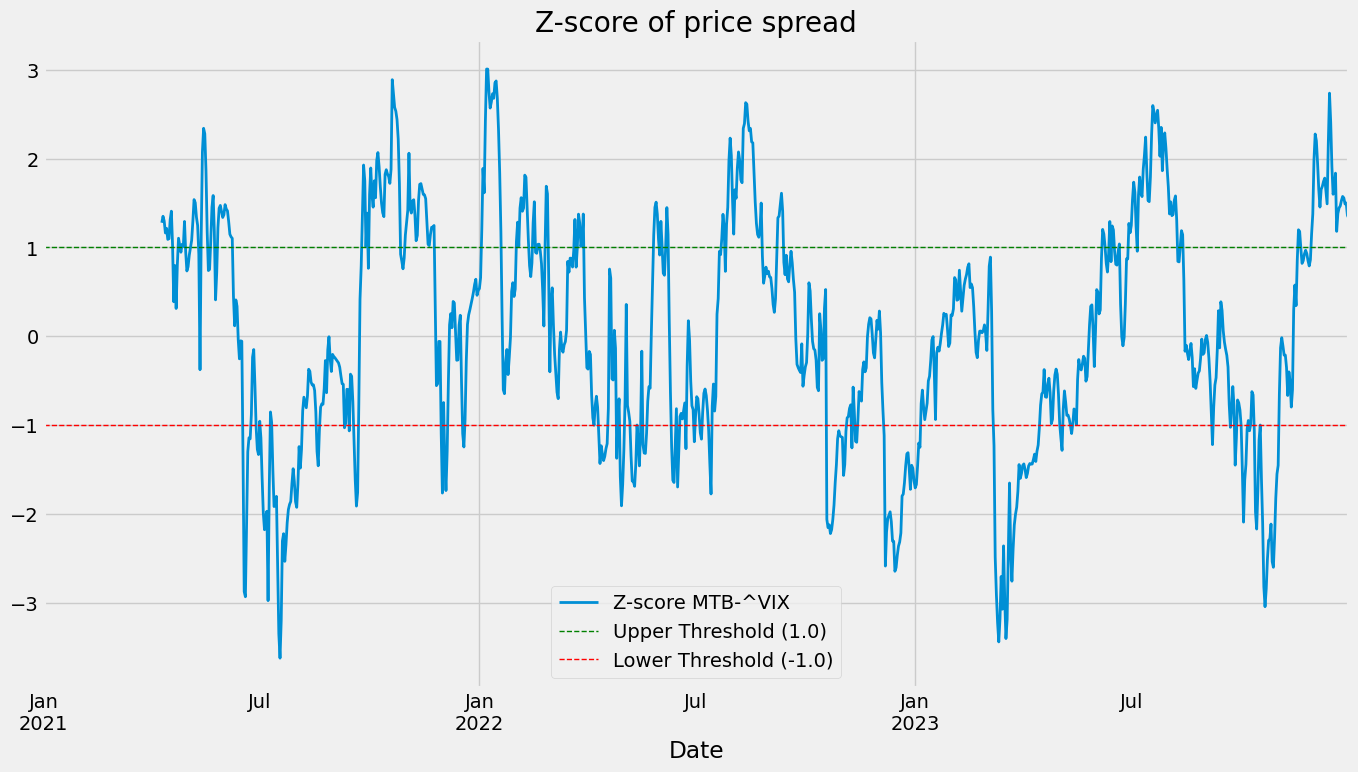

In [309]:
# Plotting the z-score of the spread of the chosen pair with a given rolling window
asset_1 = 'MTB'
asset_2 = '^VIX'
window = 100
spread = pd.DataFrame()
spread[asset_1] = cleaned_data[asset_1]
spread[asset_2] = cleaned_data[asset_2]
spread[f'{asset_1}-{asset_2}'] = spread[asset_1] - spread[asset_2]
spread[f'Z-score {asset_1}-{asset_2}'] = (spread[f'{asset_1}-{asset_2}'] - spread[f'{asset_1}-{asset_2}'].rolling(window=window).mean())/spread[f'{asset_1}-{asset_2}'].rolling(window=window).std()
spread[f'Z-score {asset_1}-{asset_2}'].plot(linewidth=2.0, figsize=(15,8))

plt.axhline(1.0, color='g', linestyle='--', linewidth=1.0, label='Upper Threshold (1.0)')
plt.axhline(-1.0, color='r', linestyle='--', linewidth=1.0, label='Lower Threshold (-1.0)')
plt.title('Z-score of price spread')
plt.legend()
plt.show()

In [310]:
# Function to determine signals and calculate PnL
def signals(df, window, initial_funds=100):
    flag = 0
    i = 0
    asset_1 = df.columns[0]
    asset_2 = df.columns[1]
    df[f'Buy {asset_1}'] = np.nan
    df[f'Sell {asset_1}'] = np.nan
    df[f'Buy {asset_2}'] = np.nan
    df[f'Sell {asset_2}'] = np.nan
    df['Funds'] = initial_funds
    df['Buy Position'] = 0
    df['Sell Position'] = 0
    
    for i in range(window, df.shape[0]):
        if flag == 0:
            if df[f'Z-score {asset_1}-{asset_2}'][i] > 1:
                # Buy asset 2 (undervalued) and sell asset 1 (overvalued)
                flag = 1
                df[f'Buy {asset_2}'][i] = df[asset_2][i]
                df[f'Sell {asset_1}'][i] = df[asset_1][i]
                df['Buy Position'][i] = df['Funds'][i]/df[f'Buy {asset_2}'][i]
                df['Sell Position'][i] = df['Funds'][i]/df[f'Sell {asset_1}'][i]
                df['Funds'][i] = df['Funds'][i-1]
            elif df[f'Z-score {asset_1}-{asset_2}'][i] < -1:
                # Buy asset 1 (undervalued) and sell asset 2 (overvalued)
                flag = -1
                df[f'Buy {asset_1}'][i] = df[asset_1][i]
                df[f'Sell {asset_2}'][i] = df[asset_2][i]
                df['Funds'][i] = df['Funds'][i-1]
                df['Buy Position'][i] = df['Funds'][i]/df[f'Buy {asset_1}'][i]
                df['Sell Position'][i] = df['Funds'][i]/df[f'Sell {asset_2}'][i]
            else:
                df['Funds'][i] = df['Funds'][i-1]
        elif flag == 1:
            if df[f'Z-score {asset_1}-{asset_2}'][i] > 1:
                # During the position "buy asset 2 (undervalued) and sell asset 1 (overvalued)"
                df['Buy Position'][i] = df['Buy Position'][i-1]
                df['Sell Position'][i] = df['Sell Position'][i-1]
                df['Funds'][i] = (df['Buy Position'][i-1] * df[asset_2][i] - df['Sell Position'][i-1] * df[asset_1][i]) + df.loc[df[f'Buy {asset_2}'].last_valid_index(), 'Funds']
            elif df[f'Z-score {asset_1}-{asset_2}'][i] <= 1:
                # Close out the position "buy asset 2 (undervalued) and sell asset 1 (overvalued)"
                flag = 0
                df[f'Sell {asset_2}'][i] = df[asset_2][i]
                df[f'Buy {asset_1}'][i] = df[asset_1][i]
                df['Funds'][i] = (df['Buy Position'][i-1] * df[asset_2][i] - df['Sell Position'][i-1] * df[asset_1][i]) + df.loc[df[f'Buy {asset_2}'].last_valid_index(), 'Funds']
            else:
                df['Funds'][i] = df['Funds'][i-1]
        elif flag == -1:
            if df[f'Z-score {asset_1}-{asset_2}'][i] < -1:
                # During the position "buy asset 1 (undervalued) and sell asset 2 (overvalued)"
                df['Buy Position'][i] = df['Buy Position'][i-1]
                df['Sell Position'][i] = df['Sell Position'][i-1]
                df['Funds'][i] = (df['Buy Position'][i-1] * df[asset_1][i] - df['Sell Position'][i-1] * df[asset_2][i]) + df.loc[df[f'Buy {asset_1}'].last_valid_index(), 'Funds']
            elif df[f'Z-score {asset_1}-{asset_2}'][i] >= -1:
                # Close out the position "buy asset 1 (undervalued) and sell asset 2 (overvalued)"
                flag = 0
                df[f'Sell {asset_1}'][i] = df[asset_1][i]
                df[f'Buy {asset_2}'][i] = df[asset_2][i]
                df['Funds'][i] = (df['Buy Position'][i-1] * df[asset_1][i] - df['Sell Position'][i-1] * df[asset_2][i]) + df.loc[df[f'Buy {asset_1}'].last_valid_index(), 'Funds']
            else:
                df['Funds'][i] = df['Funds'][i-1]

    return df

In [311]:
# Calling the function with an inital amount of 100
initial_funds = 100
strat = signals(spread, window, 100)

/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_63790/311541621.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Buy {asset_2}'][i] = df[asset_2][i]
/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_63790/311541621.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Sell {asset_1}'][i] = df[asset_1][i]
/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_63790/311541621.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

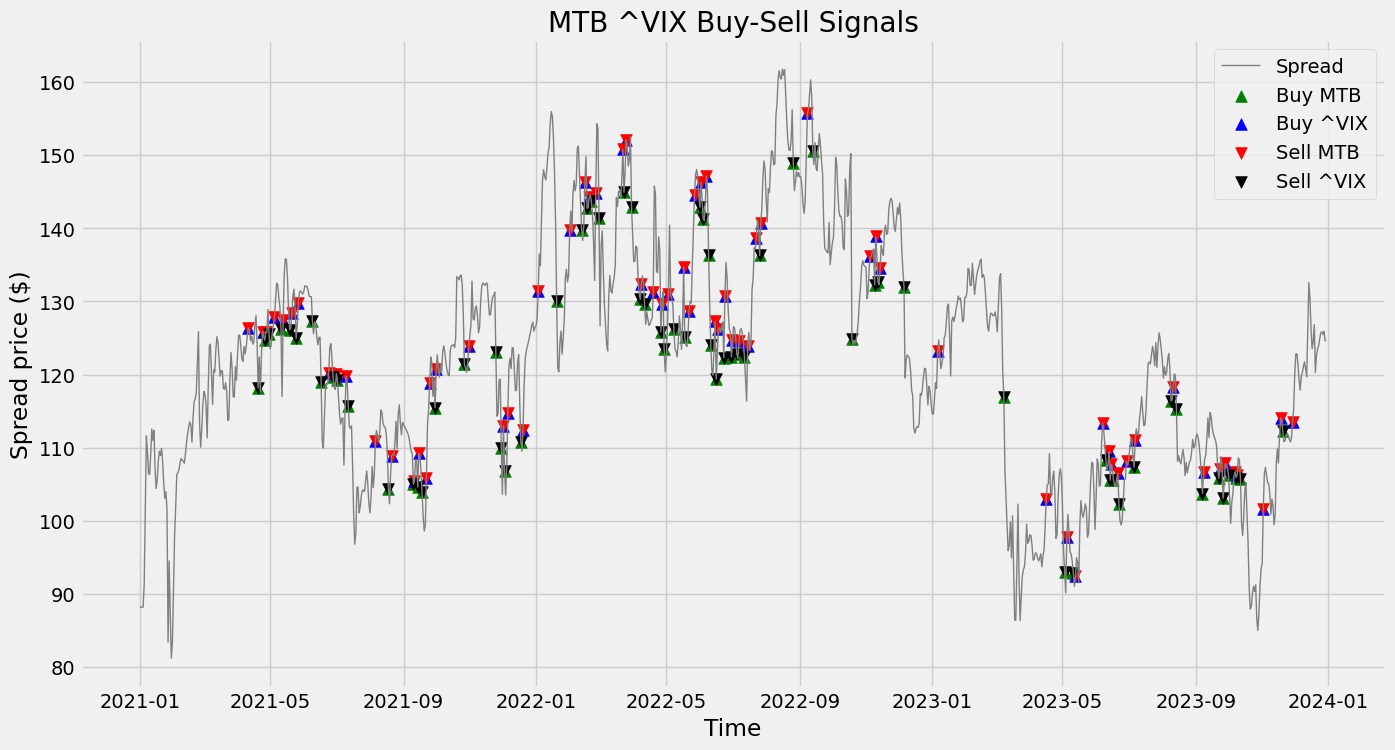

In [312]:
# Plotting the signals determined by the function
plt.figure(figsize = (15, 8))
plt.plot(strat[f'{asset_1}-{asset_2}'], label='Spread', linewidth=1.0, color='grey')
plt.scatter(strat.index, strat[f'Buy {asset_1}'] - strat[f'Sell {asset_2}'], label=f'Buy {asset_1}', marker='^', color='green', s=70)
plt.scatter(strat.index, strat[f'Sell {asset_1}'] - strat[f'Buy {asset_2}'], label=f'Buy {asset_2}', marker='^', color='blue', s=70)
plt.scatter(strat.index, strat[f'Sell {asset_1}'] - strat[f'Buy {asset_2}'], label=f'Sell {asset_1}', marker='v', color='red', s=70)
plt.scatter(strat.index, strat[f'Buy {asset_1}'] - strat[f'Sell {asset_2}'], label=f'Sell {asset_2}', marker='v', color='black', s=70)
plt.title(f'{asset_1} {asset_2} Buy-Sell Signals')
plt.xlabel('Time')
plt.ylabel('Spread price ($)')
plt.legend()
plt.show()

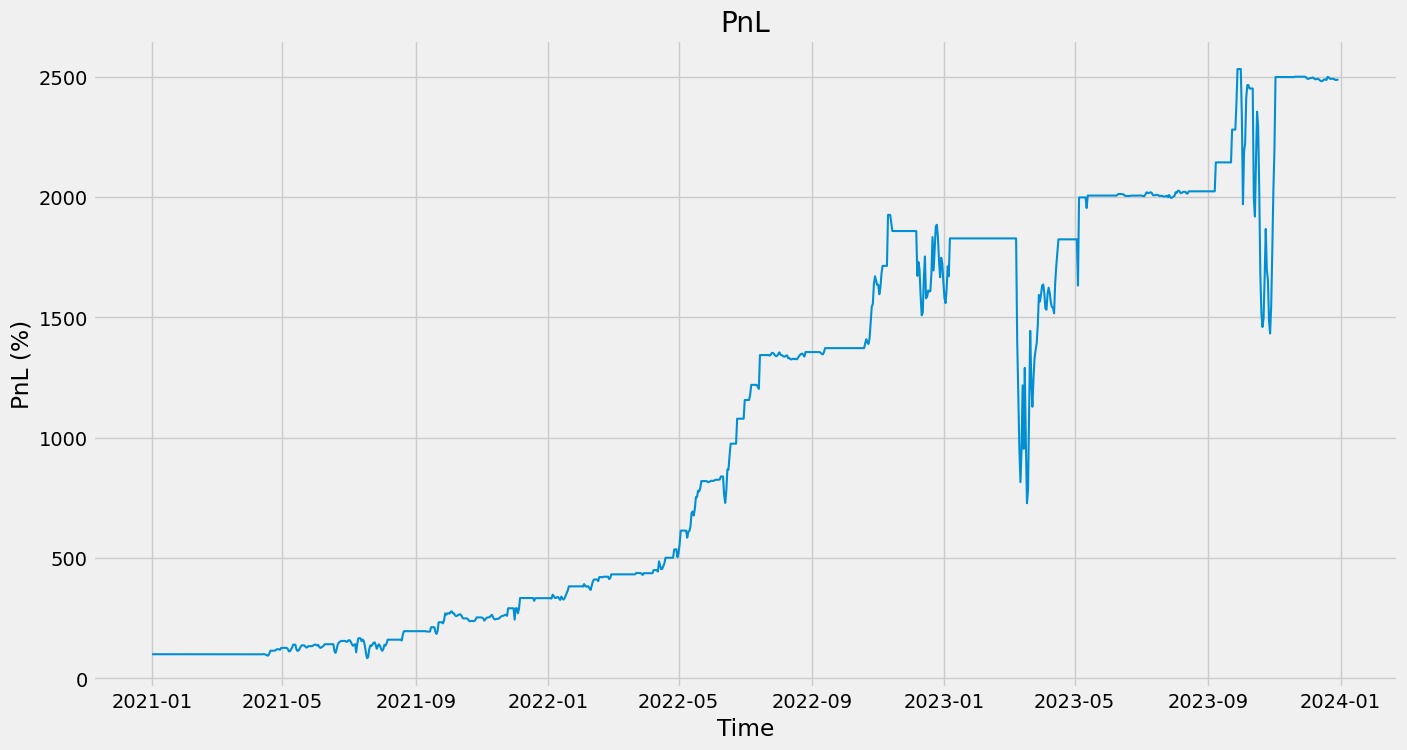

In [313]:
# Plot of the PnL from the pairs trading strategy
plt.figure(figsize=(15,8))
plt.plot((strat['Funds']/initial_funds)*100, linewidth=1.5)
plt.title('PnL')
plt.ylabel('PnL (%)')
plt.xlabel('Time')
plt.show()